# Thinking through the stats of group quantisation formats

With content from:
 - https://en.wikipedia.org/wiki/Generalized_extreme_value_distribution#Example_for_Normally_distributed_variables
 - https://en.wikipedia.org/wiki/Fisher%E2%80%93Tippett%E2%80%93Gnedenko_theorem#Examples

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
import seaborn as sns
import torch
from torch import tensor, Tensor
from typing import Any, Iterable

matplotlib.rcParams.update({"axes.spines.top": False, "axes.spines.right": False, "legend.frameon": False})

## Model of group-quantised SNR

### SNR of group-quantised formats (int etype)

In [2]:
def snr(x: Tensor, y: Tensor) -> Tensor:
    return x.pow(2).sum() / (y - x).pow(2).sum()


def quantise_int(x: Tensor, m: int) -> Tensor:
    a = x.abs().max(axis=-1, keepdim=True).values
    imax = 2**(m - 1) - 1
    q = x.div(a).mul(imax).clip_(-imax, imax).round()
    return q.div(imax).mul(a)


x = torch.randn((2**14, 32))
y = quantise_int(x, m=4)
snr(x, y)

tensor(105.8627)

In [3]:
def predict_snr_from_actual_max(x: Tensor, m: int) -> Tensor:
    e_max2 = x.abs().max(-1).values.pow(2).mean()
    return (x.pow(2).mean() / e_max2) * 3 * (2**m - 2)**2


def predict_snr(g: int, m: int) -> Tensor:
    e_max2 = 2 * (tensor(g) / 2).log()
    return (1 / e_max2) * 3 * (2**m - 2)**2


def _sweep() -> Iterable[dict[str, Any]]:
    x = torch.randn(2**20)
    for m in [4, 6, 8]:
        for g in [2**n for n in range(1, 10)]:
            xg = x.view(-1, g)
            yield dict(m=m, g=g, kind="empirical", snr=snr(xg, quantise_int(xg, m)).item())
            yield dict(m=m, g=g, kind="model-hybrid", snr=predict_snr_from_actual_max(xg, m).item())
            yield dict(m=m, g=g, kind="model", snr=predict_snr(g, m).item())


df = pd.DataFrame.from_records(_sweep())
df.head()

,m,g,kind,snr
0,4,2,empirical,719.448853
1,4,2,model-hybrid,359.185089
2,4,2,model,inf
3,4,4,empirical,317.005493
4,4,4,model-hybrid,237.811676


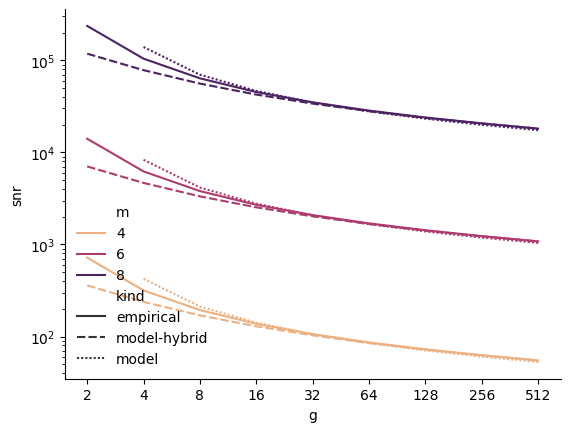

In [4]:
ax = sns.lineplot(data=df, y="snr", x="g", hue="m", style="kind", palette="flare", hue_norm=matplotlib.colors.LogNorm())
ax.set_yscale("log")
ax.set_xscale("log", base=2)
ax.xaxis.set_major_formatter("{x:.0f}")

### Maximum of folded normal

/home/ubuntu/SquashedLlama/.venv/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:3259: RuntimeWarning: invalid value encountered in divide
  sc.expm1(sc.gammaln(2.0*c+1.0)-2*sc.gammaln(c + 1.0))/c**2.0)
/home/ubuntu/SquashedLlama/.venv/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:3261: RuntimeWarning: invalid value encountered in divide
  gamk = np.where(abs(c) < eps, -_EULER, sc.expm1(sc.gammaln(c + 1))/c)
/home/ubuntu/SquashedLlama/.venv/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:3270: RuntimeWarning: invalid value encountered in divide
  np.sign(c)*(-g3 + (g2 + 2*g2mg12)*g1)/g2mg12**1.5,
/home/ubuntu/SquashedLlama/.venv/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:3278: RuntimeWarning: invalid value encountered in divide
  (g4 + (-4*g3 + 3*(g2 + g2mg12)*g1)*g1)/g2mg12**2,
/home/ubuntu/SquashedLlama/.venv/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:1174: RuntimeWarning: invalid value encounte

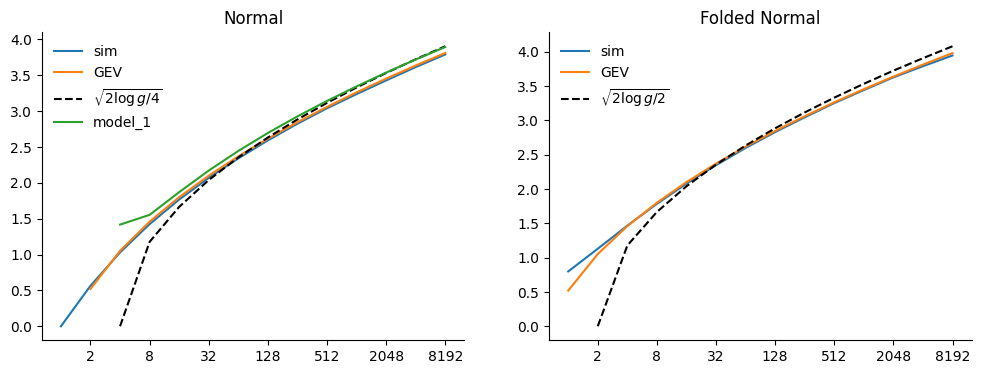

In [5]:
x = torch.randn(2**20)
gs = 2**torch.arange(14)
e_sim = tensor([x.view(-1, g).max(-1).values.mean() for g in gs])
ef_sim = tensor([x.abs().view(-1, g).max(-1).values.mean() for g in gs])

g_mu = scipy.stats.norm.ppf(1 - 1 / gs)
g_sigma = scipy.stats.norm.ppf(1 - 1 / (gs * torch.e)) - scipy.stats.norm.ppf(1 - 1 / gs)
e_gen = scipy.stats.genextreme.mean(0, g_mu, g_sigma)

gf_mu = scipy.stats.norm.ppf(1 - 1 / (2*gs))
gf_sigma = scipy.stats.norm.ppf(1 - 1 / (2 * gs * torch.e)) - scipy.stats.norm.ppf(1 - 1 / (2*gs))
ef_gen = scipy.stats.genextreme.mean(0, gf_mu, gf_sigma)

_, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 4))
ax0.set_title("Normal")
ax0.plot(gs, e_sim, label="sim")
ax0.plot(gs, e_gen, label="GEV")
ax0.plot(gs, (2 * (gs/4).log()).sqrt(), "k--", label=r"$\sqrt{2 \log g/4}$")
ax0.plot(gs, (gs ** 2 / (2 * torch.pi * (gs**2 / (2 * torch.pi)).log())).log().sqrt() * (1 + .577 / gs.log()),
        label="model_1")

ax1.set_title("Folded Normal")
ax1.plot(gs, ef_sim, label="sim")
ax1.plot(gs, ef_gen, label="GEV")
ax1.plot(gs, (2 * (gs/2).log()).sqrt(), "k--", label=f"$\\sqrt{{2 \\log g/2}}$")

for ax in [ax0, ax1]:
    ax.legend()
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter("{x:.0f}")

## Optimal etype

A few options:
 - Same mass in each bin (NF4 - QLoRA)
 - Lloyd-Max to optimise RMS
 - Smooth RMS-optimal ($\delta \propto \sqrt[3]{p}$)

### Optimal quantisation of Normal

NF4 SNR tensor(55.8922)
NF''4 SNR tensor(33.8093)
NF'4 SNR tensor(49.8193)
LM SNR tensor(105.0981)
CR SNR tensor(105.1787)
CR' SNR tensor(105.1787)


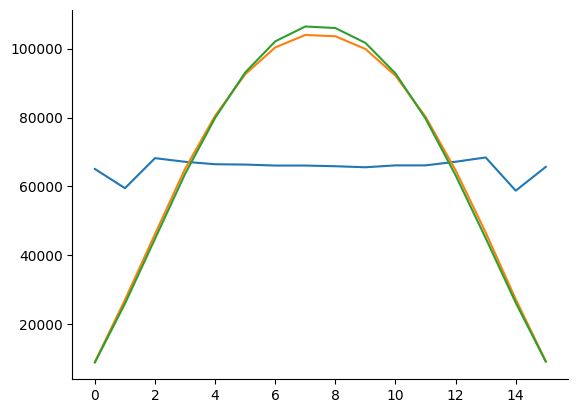

In [ ]:
def snr(x: Tensor, y: Tensor) -> Tensor:
    return x.pow(2).sum() / (y - x).pow(2).sum()


def quantise_table(x: Tensor, table: Tensor) -> Tensor:
    x_flat = x.flatten()
    i = torch.cdist(table[:, None], x_flat[:, None]).argmin(0)
    return table[i].view(x.shape)


def nf_table(m: int) -> Tensor:
    i = 1 + torch.arange(2**m - 1)
    t = tensor(scipy.stats.norm.ppf(i / (2**m)), dtype=torch.float32)
    t = torch.cat([(1.5 * t[0] - 0.5 * t[1])[None], (t[1:] + t[:-1]) / 2, (1.5 * t[-1] - 0.5 * t[-2])[None]])
    return t


def lloyd_max_normal(m: int, iterations: int) -> Tensor:
    v = torch.linspace(-1, 1, 2**m)
    for _ in range(iterations):
        t = torch.cat([tensor(-torch.inf)[None], (v[1:] + v[:-1]) / 2, tensor(torch.inf)[None]])
        tp = tensor(scipy.stats.norm.pdf(t), dtype=torch.float32)
        tc = tensor(scipy.stats.norm.cdf(t), dtype=torch.float32)
        v = (tp[:-1] - tp[1:]) / (tc[1:] - tc[:-1])
    assert torch.equal(torch.sort(v).values, v)
    return v


def cubert_normal_numerical(m: int, steps: int = 2**20) -> Tensor:
    # Numerical 'inverse CDF'
    i = torch.linspace(-10, 10, steps)
    c = torch.cumsum(tensor(scipy.stats.norm.pdf(i), dtype=torch.float32)**(1/3), 0)
    idx = (c < torch.linspace(0, c[-1], 2**m + 2)[1:-1, None]).sum(1)
    return i[idx]


def cubert_normal(m: int) -> Tensor:
    return tensor(
        scipy.stats.norm.ppf(torch.linspace(0, 1, 2**m + 2), scale=3**.5)[1:-1],
        dtype=torch.float32,
    )


NF4 = tensor([
    -1.0, -0.6961928009986877, -0.5250730514526367, -0.39491748809814453, -0.28444138169288635, -0.18477343022823334, -0.09105003625154495,
    0.0,
    0.07958029955625534, 0.16093020141124725, 0.24611230194568634, 0.33791524171829224, 0.44070982933044434, 0.5626170039176941, 0.7229568362236023, 1.0
])

torch.manual_seed(100)
x = torch.randn(2**20)

print("NF4 SNR", snr(x, x.abs().max() * quantise_table(x / x.abs().max(), NF4)))
print("NF''4 SNR", snr(x, quantise_table(x, nf_table(4))))
t = nf_table(4)
t /= t.abs().max()
print("NF'4 SNR", snr(x, x.abs().max() * quantise_table(x / x.abs().max(), t)))

print("LM SNR", snr(x, quantise_table(x, lloyd_max_normal(4, 100))))
print("CR SNR", snr(x, quantise_table(x, cubert_normal(4))))
print("CR' SNR", snr(x, quantise_table(x, cubert_normal_numerical(4))))

t = nf_table(4)
plt.plot(torch.bincount(torch.cdist(t[:, None], x[:, None]).argmin(0)))
t = lloyd_max_normal(4, 100)
plt.plot(torch.bincount(torch.cdist(t[:, None], x[:, None]).argmin(0)))
t = cubert_normal(4)
plt.plot(torch.bincount(torch.cdist(t[:, None], x[:, None]).argmin(0)))

### What floating point format is best?

Empirically, well-scaled E2M* looks best for RMS error. Can the cube root rule explain this?

The optimal density of codepoints at $x$ should be $\propto\sqrt[3]{\mathrm{p}(x)}$.

E2M* exponent multipliers are `[sub, 0.5, 1, 2]`.

/tmp/ipykernel_4142/486944240.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax.plot(x, limit * scipy.stats.norm.pdf(x)**(1/3), color="k")


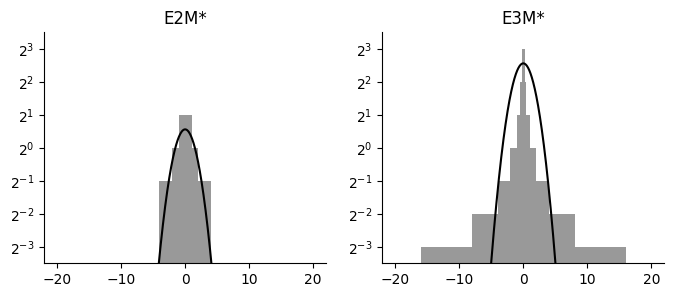

In [7]:
x = torch.linspace(-20, 20, 2**20)

_, axs = plt.subplots(ncols=2, figsize=(8, 3))
for ax, (label, expm) in zip(axs, [("E2M*", tensor([0.5, 1, 2])),
                                   ("E3M*", tensor([0.125, 0.25, 0.5, 1, 2, 4, 8]))]):
    ax.bar(torch.zeros_like(expm), 1/expm, 4*expm, color="#999")
    limit = (1/expm).max()
    ax.plot(x, limit * scipy.stats.norm.pdf(x)**(1/3), color="k")
    ax.set_yscale("log", base=2)
    ax.set_ylim((2**-3.5, 2**3.5))
    ax.set_title(label)

### What is the distribution & optimal quantiser for group-absmax-normalised normals?



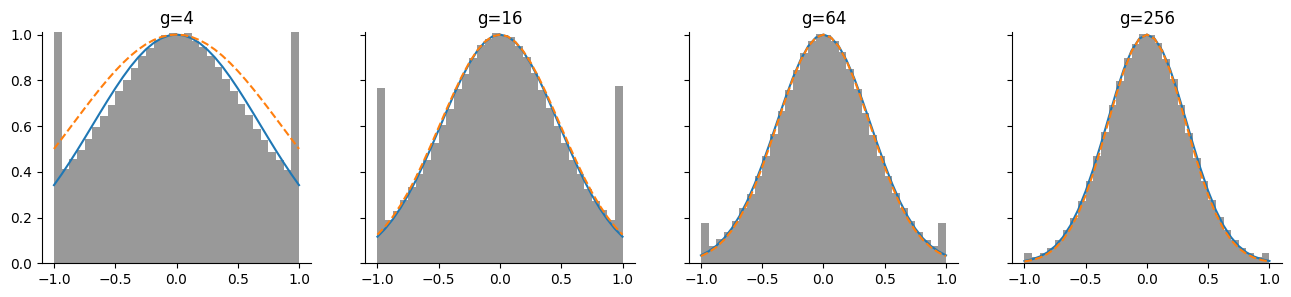

In [8]:
x = torch.randn(2**20)

gs = [4, 16, 64, 256]
_, ax = plt.subplots(ncols=len(gs), figsize=(4*len(gs), 3), sharey=True, squeeze=False)

for g, ax in zip(gs, ax.flatten()):
    ax.set_title(f"g={g}")
    xg = x.view(-1, g)
    xm = xg.abs().max(dim=-1, keepdim=True).values
    xn = (xg / xm).flatten()

    bins = torch.linspace(-1, 1, 2**5+1)
    h = torch.histogram(xn, bins).hist.float()
    h = h / h[len(h)//2]
    ax.bar((bins[1:] + bins[:-1])/2, h, width=(bins[1] - bins[0]), color="#999")

    ax.plot(bins, scipy.stats.norm.pdf(bins * xm.mean()) / scipy.stats.norm.pdf(0))
    model_max = tensor(g).div(2).log().mul(2).sqrt()
    ax.plot(bins, scipy.stats.norm.pdf(bins * model_max) / scipy.stats.norm.pdf(0), ls="--")
    ax.set_ylim((0, 1.01))

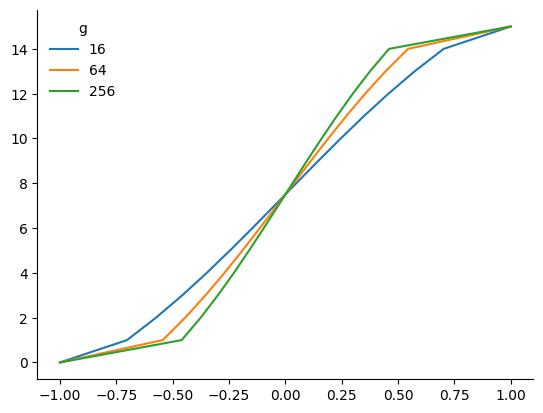

In [13]:
m = 4
g = 16
for g in [16, 64, 256]:
    t = scipy.stats.truncnorm.ppf(torch.linspace(0, 1, 2**m), -1, 1, scale=3**.5 / tensor(g).div(2).log().mul(2).sqrt())[1:-1]
    t = torch.cat([tensor([-1]), tensor(t), tensor([1])])
    plt.plot(t, torch.arange(len(t)), label=str(g))
plt.legend(title="g")

# TODO plot E2M1 and INT4 on this
# TODO try & compare lloyd-max quantiser

### Distribution and optimal quantiser for laplace?

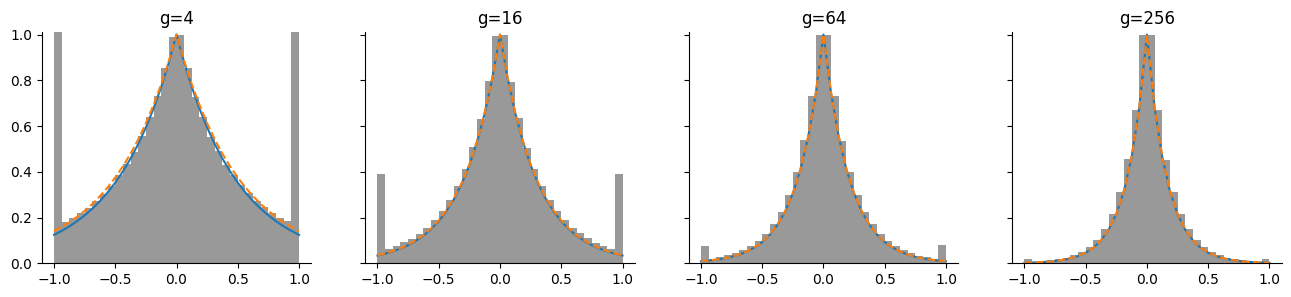

In [12]:
x = torch.distributions.Laplace(0, 1).sample((2**20,))

gs = [4, 16, 64, 256]
_, ax = plt.subplots(ncols=len(gs), figsize=(4*len(gs), 3), sharey=True, squeeze=False)

for g, ax in zip(gs, ax.flatten()):
    ax.set_title(f"g={g}")
    xg = x.view(-1, g)
    xm = xg.abs().max(dim=-1, keepdim=True).values
    xn = (xg / xm).flatten()

    bins = torch.linspace(-1, 1, 2**5+1)
    h = torch.histogram(xn, bins).hist.float()
    h = h / h[len(h)//2]
    ax.bar((bins[1:] + bins[:-1])/2, h, width=(bins[1] - bins[0]), color="#999")

    ax.plot(bins, scipy.stats.laplace.pdf(bins * xm.mean()) / scipy.stats.laplace.pdf(0))
    model_max = 0.577 + tensor(g).log()
    ax.plot(bins, scipy.stats.laplace.pdf(bins * model_max) / scipy.stats.laplace.pdf(0), ls="--")
    ax.set_ylim((0, 1.01))